# Background

## Objective

I recently found a group of friends to watch horror movies with. Despite our similar interests, it takes us forever to pick a movie every time. One can only imagine it getting harder for groups with more diverse interests. To make movie nights easier, I want to **build a recommender system that makes movie recommendations for a group of users**.

In this project, I'm prototyping such a group movie recommender. I envision the full-fledge product either being a stand-alone application or integrated with streaming services such as Netflix, Hulu, Prime Video, etc.

## Dataset

[MovieLens](https://grouplens.org/datasets/movielens/) and the [Netflix Prize Data](https://www.kaggle.com/netflix-inc/netflix-prize-data) are the two most popular datasets for building movie recommender systems. Both are publicly available and use **explicit** (0 to 5 stars) as opposed to implicit (e.g., click, view, or purchase) ratings. The Netflix data is much older, with movies released between 1998 and 2005, whereas the MovieLens data was updated in December, 2019. To make more up-to-date recommendations for a wider age range, I'll build my recommender system on the MovieLens data. Due to training time concerns, I'll use the version with 10 thousand rather than 2.5 million user ratings.

## Approaches

Apparently, most users only rated a small subset of movies in the dataset. To make recommendations is solve the rating prediction problem: **How would each user rate movies that they haven't rated yet?**

<figure>
  <img src="img/sparse_matrix.png" width="400">
  <figcaption>
      A sparse matrix with mostly missing ratings (from <a href="http://nicolas-hug.com/blog/matrix_facto_1">Nicolas Hug's blog</a>).
    </figcaption>
</figure>

Many information filtering algorithms are used to solve this problem, most of which fall under three categories:
- **Content-based filtering**: Make recommendations based on item (e.g., genre, year, director, actor, etc.) or user (e.g., age, gender, race/ethnicity, etc.) features.
- **Collaborative filtering**: Make recommendations based on user-item interactions (e.g., how users rate movies).
- **Hybrid approach**: Make recommendations based on both features of items and items and their iterations.

These algorithms can predict ratings for movies a user hasn't rated yet. Then movies with the highest predicted ratings will be recommended to this user. Compared to content-based filtering, collaborative filtering requires much less information (i.e., no need to specify user or item features) yet generally achieves stronger results. Of course, it's more ideal if we can combine user/item features with historical interactions. 

As a good starting place, I will use collaborative filtering to make recommendations for each user in this project. In the future, we can add user/item features to improve the system. One of the best-performing algorithm for collaborative filtering is [singular value decomposition (SVD)](http://nicolas-hug.com/blog/matrix_facto_2), which is illustrated below. 


<figure>
  <img src="img/svd.png" width="500">
  <figcaption>
      Illustration of SVD (from <a href="http://nicolas-hug.com/blog/matrix_facto_2">Nicolas Hug's blog</a>).
    </figcaption>
</figure>

In this context, SVD factorizes the user-item matrix into two smaller matrices: A user-feature matrix and a feature-item matrix. Unlike content-based filtering, here we're talking about latent features (usually we don't know what they are) discovered in user-item interactions rather than explicitly defined. Factorization can be found via gradient descent. SVD++ is an extension of SVD and takes account of not just the ratings but also the fact that a user rated some movies but not others. SVD++ is the best performing algorithm on many datasets.

## Evaluation
How do we know if a recommender system is any good? Using SVD and its variants, not only can we predict ratings for unrated movies but also ratings for movies that are already rated. For the latter, we can compare actual ratings with predict ratings using metrics that we would normally use for regression, such as root-mean-square error (RMSE). I'll use RMSE both during hyperparameter tuning and when validating the trained model on the test set.

# Prepare data

In [1]:
# Import libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import sklearn.model_selection
import surprise.model_selection
from surprise import accuracy
from surprise import dump
from surprise import Dataset, Reader, SVDpp, NormalPredictor
from surprise.model_selection import GridSearchCV

sns.set_context("notebook", font_scale=1.3)
sns.set_palette("tab10")

%load_ext lab_black

## Load data

In [2]:
# Load rating and movie data
data_df = pd.read_csv("ml-latest-small/ratings.csv")

movies_df = pd.read_csv("ml-latest-small/movies.csv")

## Split data
To avoid data leakage, I'm splitting the data into three different sets: The validation set for hyperparameter tuning, the training set for modeling training, and the testing set for model evaluation. 

In [3]:
# Save 20% of the data for hyperparameter tuning
validation_df, rest_df = sklearn.model_selection.train_test_split(
    data_df, test_size=0.2
)

# Convert DataFrame to Reader objects
reader = Reader(rating_scale=(0.5, 5.0))

data = Dataset.load_from_df(data_df[["userId", "movieId", "rating"]], reader)

validation = Dataset.load_from_df(
    validation_df[["userId", "movieId", "rating"]], reader
)

rest = Dataset.load_from_df(rest_df[["userId", "movieId", "rating"]], reader)

# Save 20% of the data for testing
train, test = surprise.model_selection.train_test_split(rest, test_size=0.2)

## Exploratory data analysis

### Average ratings

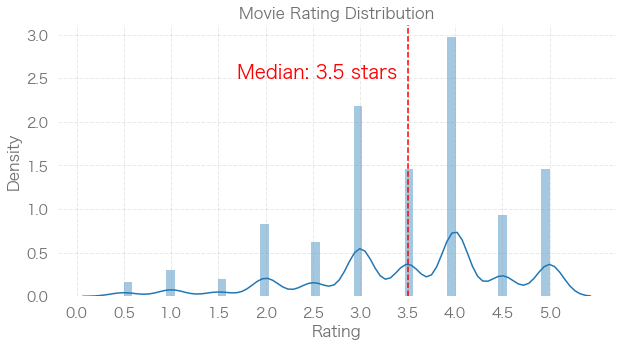

In [4]:
# Density plot of ratings
plt.figure(figsize=(10, 5))
sns.distplot(rest_df["rating"])
plt.axvline(rest_df["rating"].median(), color="r", linestyle="--")
plt.title("Movie Rating Distribution")
plt.xlabel("Rating")
plt.xticks(np.arange(0, 5.5, step=0.5))
plt.ylabel("Density")
plt.text(
    rest_df["rating"].median() - 1.8,
    2.5,
    f'Median: {rest_df["rating"].median()} stars',
    horizontalalignment="left",
    size="large",
    color="red",
    weight="semibold",
)
plt.show()

MovieLens uses a scale from 0 to 5 stars with half-star increments. The rating distribution is skewed to the left, with most movies rated highly (3.5 stars or above). This makes sense because users may be more motivated to rate movies they liked or just remember them better to give ratings a while after viewing.

### Number of ratings

#### Per movie

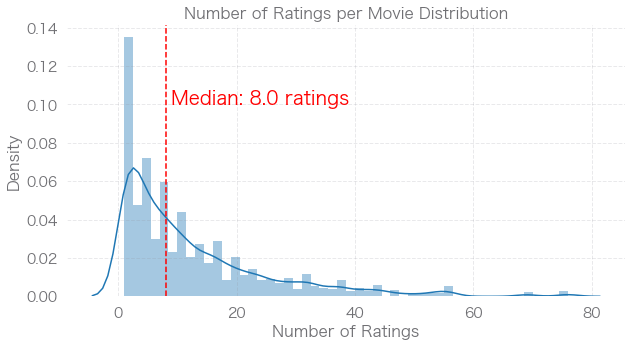

In [5]:
# Count the number of ratings received by each movie
num_ratings_movie = pd.DataFrame(
    rest_df.groupby("movieId").count()["rating"]
).reset_index()

# Add this information to the original data frame
df_movie_num = pd.merge(left=rest_df, right=num_ratings_movie, on="movieId")
df_movie_num.rename(
    columns={"rating_x": "rating", "rating_y": "numRatings"}, inplace=True
)

# Density plot of the number of ratings
plt.figure(figsize=(10, 5))
sns.distplot(df_movie_num["numRatings"])
plt.axvline(df_movie_num["numRatings"].median(), color="r", linestyle="--")
plt.title("Number of Ratings per Movie Distribution")
plt.xlabel("Number of Ratings")
plt.ylabel("Density")
plt.text(
    df_movie_num["numRatings"].median() + 1,
    0.1,
    f'Median: {df_movie_num["numRatings"].median()} ratings',
    horizontalalignment="left",
    size="large",
    color="red",
    weight="semibold",
)
plt.show()

Most movies received fewer than 8 ratings whereas some received as many as 70. As is often the case in collaborative filtering, among movies with similar ratings, the ones that are more popular will be more likely to get recommended.

#### Per user

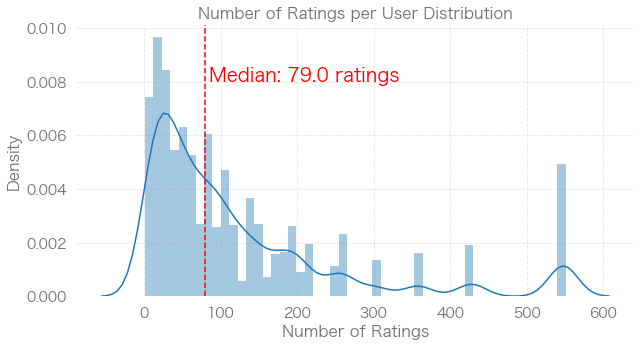

In [6]:
# Count the number of ratings given by each user
num_ratings_user = pd.DataFrame(
    rest_df.groupby("userId").count()["rating"]
).reset_index()

# Add this information to the original data frame
df_user_num = pd.merge(left=rest_df, right=num_ratings_user, on="userId")
df_user_num.rename(
    columns={"rating_x": "rating", "rating_y": "numRatings"}, inplace=True
)

# Density plot of the number of ratings
plt.figure(figsize=(10, 5))
sns.distplot(df_user_num["numRatings"])
plt.axvline(df_user_num["numRatings"].median(), color="r", linestyle="--")
plt.title("Number of Ratings per User Distribution")
plt.xlabel("Number of Ratings")
plt.ylabel("Density")
plt.text(
    df_user_num["numRatings"].median() + 5,
    0.008,
    f'Median: {df_user_num["numRatings"].median()} ratings',
    horizontalalignment="left",
    size="large",
    color="red",
    weight="semibold",
)
plt.show()

MovieLens users really rated quite a lot of movies, with the median being 74 ratings per user and the maximum above 500. The relative high density is one of the reasons why MovieLens is great for building movie recommenders. 

### Number of ratings per movie vs. rating

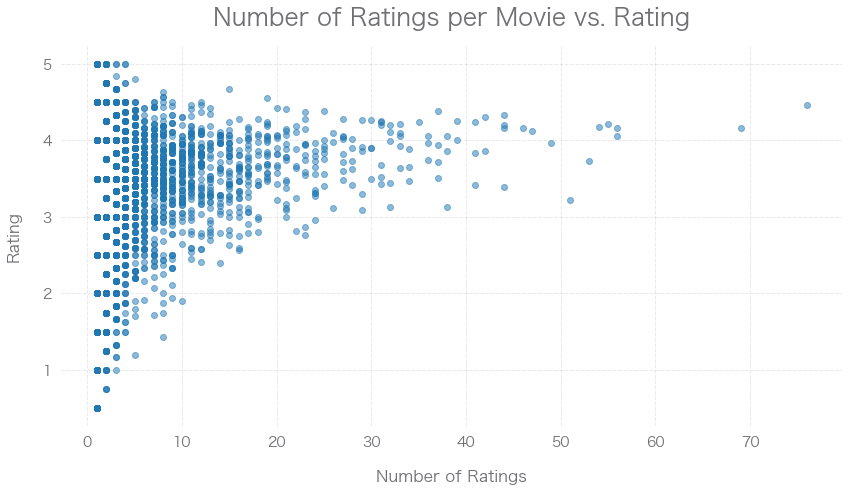

In [7]:
# Extract the average rating of each movie and the number of ratings it received
ratings_movie = pd.DataFrame()
ratings_movie["meanRating"] = df_movie_num.groupby("movieId")["rating"].mean().values
ratings_movie["numRatings"] = df_movie_num.groupby("movieId")["rating"].count().values

# Plot number of ratings per movie vs. rating
fig, ax = plt.subplots(figsize=(14, 7))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Number of Ratings per Movie vs. Rating", fontsize=24, pad=20)
ax.set_xlabel("Number of Ratings", fontsize=16, labelpad=20)
ax.set_ylabel("Rating", fontsize=16, labelpad=20)

plt.scatter(ratings_movie["numRatings"], ratings_movie["meanRating"], alpha=0.5)
plt.show()

A common complaints about collaborative filtering is that it likes to recommend popular items. However, this may not so bad since popular movies tend to be highly rated. After all, these movies are popular for a reason. So even though *The Shawshank Redemption* may seem like a cliché, it is nonetheless a safe option for someone who's never watched it.

# Build a recommender

## Model tuning
First, let's find the optimal value of each hyperparameter before training. Since training SVD++ is computationally expensive and takes a long time, we'd better not get greedy and just focus on two hyperparameters: `lr_all` (the learning rate for all parameters) and `reg_all` (the regularization term for all parameters).

In [8]:
# Define the hyperparameter space
param_grid = {"lr_all": [0.005, 0.01], "reg_all": [0.02, 0.1]}

# Use grid search to find the best SVD++ estimator
gs = GridSearchCV(SVDpp, param_grid, measures=["rmse"], n_jobs=-1, cv=3)

gs.fit(validation)

algo = gs.best_estimator["rmse"]

## Model training
Next, let's train the model on the training data and save the trained model for later use. 

In [9]:
# Train the algorithm on the train set
algo.fit(train)

# Save the model
dump.dump("best_svd", algo=algo)

## Model evaluation
To evaluate our trained model, we can use it to predict ratings in the testing data it has never seen. 

In [10]:
# Predict ratings for the test set
predictions = algo.test(test)

# Compute RMSE
accuracy.rmse(predictions)

RMSE: 0.9142


0.9141755789070655

RMSE in the testing data is 0.91. It's hard to tell how good it is without comparing this result to that achieved by baseline algorithms such as the `NormalPredictor`. This simple algorithm predicts a random rating based on the distribution of the training set (assumed to be normal).

In [11]:
# Create a model object
baseline = NormalPredictor()

# Fit it on the training data
baseline.fit(train)

# Predict ratings for the test set
baseline_predictions = baseline.test(test)

# Compute RMSE
accuracy.rmse(baseline_predictions)

RMSE: 1.4433


1.4433055733293143

RMSE of the `NormalPredictor` algorithm is 1.44, suggesting that our SVD++ algorithm which utilizes user-item interactions indeed makes better-than-random recommendations.